In [1]:
from matplotlib import pyplot as plt

from tqdm import tqdm
from PIL import Image as Img
from keras import Input
from keras.layers import Dense, Reshape, LeakyReLU, Conv2D, Conv2DTranspose, Flatten, Dropout
from keras.models import Model
from tensorflow.keras.optimizers import RMSprop
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import numpy as np

images=np.load('/content/drive/MyDrive/brain tumor segmentation/asad data/data/appended all/training/appended masks/masks.npy')

In [8]:
image2D = []
#mask2D = []
for i in range(195):
  for j in range(128):
    
    image2D.append(images[i,:,:,j])
    #mask2D.append(y[i,:,:,j])
images = np.array(image2D)
#y = np.array(mask2D)

In [31]:
WIDTH = 128
HEIGHT = 128
images = np.expand_dims(images, axis = 3)

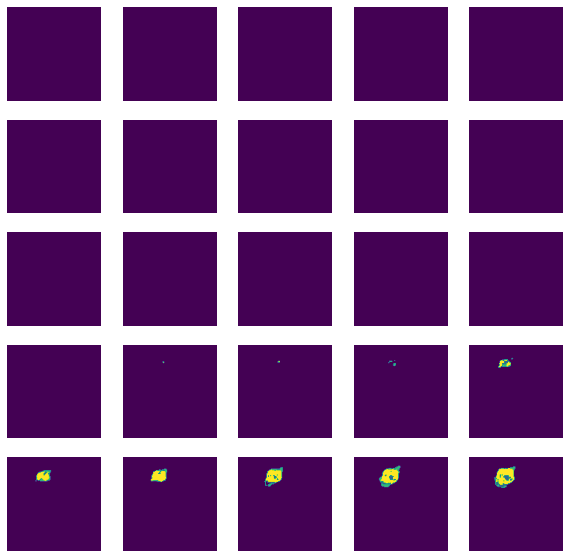

In [10]:
plt.figure(1, figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(images[i])
    plt.axis('off')
plt.show()

In [12]:
LATENT_DIM = 32
CHANNELS = 1

def create_generator():
    gen_input = Input(shape=(LATENT_DIM, ))

    x = Dense(128 * 16 * 16)(gen_input)
    x = LeakyReLU()(x)
    x = Reshape((16, 16, 128))(x)

    x = Conv2D(256, 5, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)
    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2D(512, 5, padding='same')(x)
    x = LeakyReLU()(x)
    x = Conv2D(512, 5, padding='same')(x)
    x = LeakyReLU()(x)
    x = Conv2D(CHANNELS, 7, activation='tanh', padding='same')(x)

    generator = Model(gen_input, x)
    return generator

In [14]:
def create_discriminator():
    disc_input = Input(shape=(HEIGHT, WIDTH, CHANNELS))

    x = Conv2D(256, 3)(disc_input)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)
    x = Flatten()(x)
    x = Dropout(0.4)(x)

    x = Dense(1, activation='sigmoid')(x)
    discriminator = Model(disc_input, x)

    optimizer = RMSprop(
        lr=.0001,
        clipvalue=1.0,
        decay=1e-8
    )

    discriminator.compile(
        optimizer=optimizer,
        loss='binary_crossentropy'
    )

    return discriminator

In [15]:
from IPython.display import Image
from keras.utils.vis_utils import model_to_dot

In [16]:
generator = create_generator()
generator.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32)]              0         
                                                                 
 dense (Dense)               (None, 32768)             1081344   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32768)             0         
                                                                 
 reshape (Reshape)           (None, 16, 16, 128)       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 256)       819456    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 256)       0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 32, 32, 256)      104883

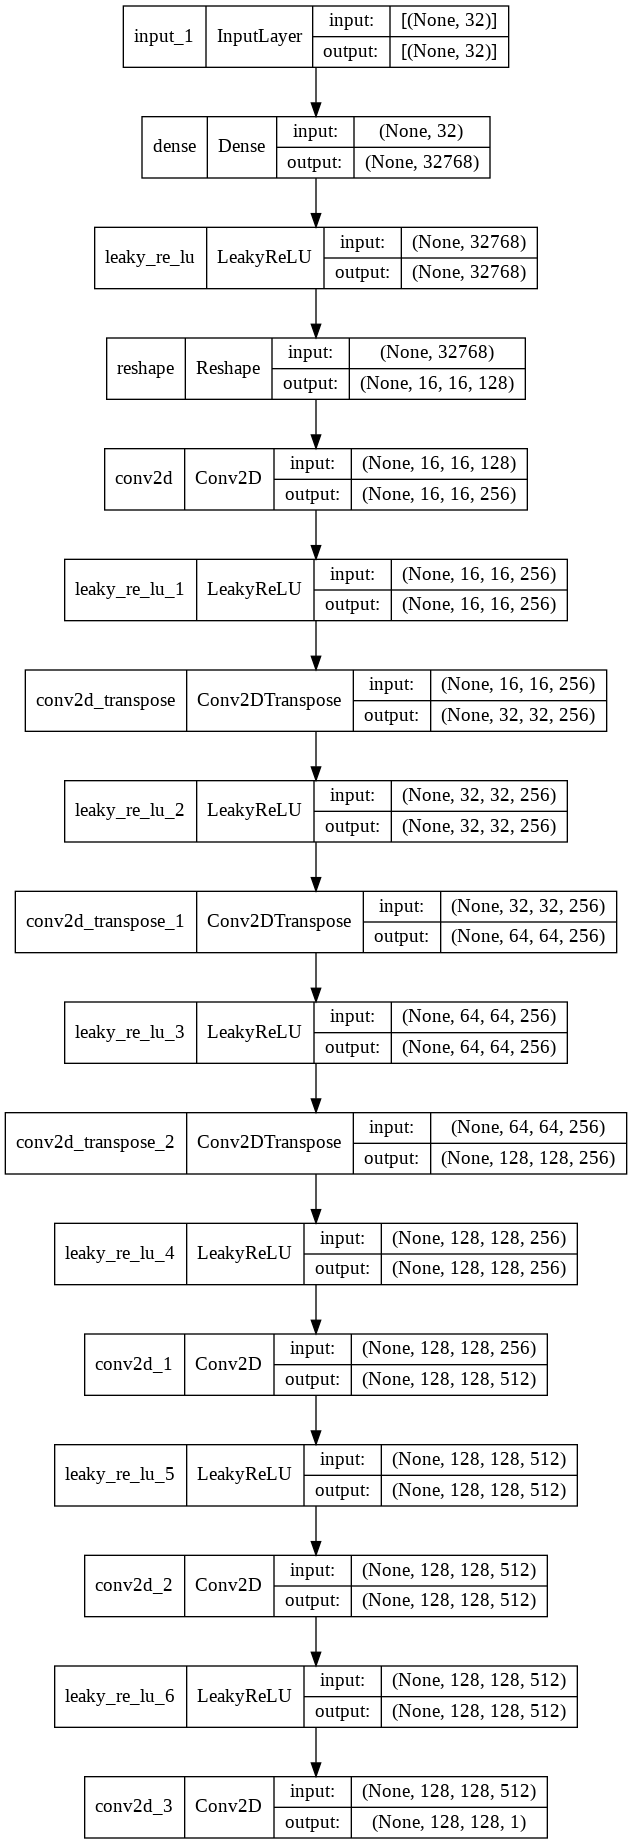

In [17]:
Image(model_to_dot(generator, show_shapes=True).create_png())

In [20]:
discriminator = create_discriminator()
discriminator.trainable = False
discriminator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 126, 126, 256)     2560      
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 126, 126, 256)     0         
                                                                 
 conv2d_5 (Conv2D)           (None, 62, 62, 256)       1048832   
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 62, 62, 256)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 30, 30, 256)       1048832   
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 30, 30, 256)       0   

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [21]:
gan_input = Input(shape=(LATENT_DIM, ))
gan_output = discriminator(generator(gan_input))
gan = Model(gan_input, gan_output)

In [22]:
optimizer = RMSprop(lr=.0001, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=optimizer, loss='binary_crossentropy')

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [23]:
gan.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32)]              0         
                                                                 
 model (Functional)          (None, 128, 128, 1)       14903809  
                                                                 
 model_1 (Functional)        (None, 1)                 4207105   
                                                                 
Total params: 19,110,914
Trainable params: 14,903,809
Non-trainable params: 4,207,105
_________________________________________________________________


In [44]:
import time
iters = 15000
batch_size = 16

RES_DIR = 'res2'
FILE_PATH = '%s/generated_%d.png'
if not os.path.isdir(RES_DIR):
    os.mkdir(RES_DIR)

CONTROL_SIZE_SQRT = 6
control_vectors = np.random.normal(size=(CONTROL_SIZE_SQRT**2, LATENT_DIM)) / 2

start = 0
d_losses = []
a_losses = []
images_saved = 0
for step in range(iters):
    start_time = time.time()
    latent_vectors = np.random.normal(size=(batch_size, LATENT_DIM))
    generated = generator.predict(latent_vectors)

    real = images[start:start + batch_size]
    combined_images = np.concatenate([generated, real])

    labels = np.concatenate([np.ones((batch_size, 1)), np.zeros((batch_size, 1))])
    labels += .05 * np.random.random(labels.shape)

    d_loss = discriminator.train_on_batch(combined_images, labels)
    d_losses.append(d_loss)

    latent_vectors = np.random.normal(size=(batch_size, LATENT_DIM))
    misleading_targets = np.zeros((batch_size, 1))

    a_loss = gan.train_on_batch(latent_vectors, misleading_targets)
    a_losses.append(a_loss)

    start += batch_size
    #print('%d/%d: d_loss: %.4f,  a_loss: %.4f.  (%.1f sec)' % (step + 1, iters, d_loss, a_loss, time.time() - start_time))
    if start > images.shape[0] - batch_size:
        start = 0
    if step % 50 == 49:
      print('%d/%d: d_loss: %.4f,  a_loss: %.4f.  (%.1f sec)' % (step + 1, iters, d_loss, a_loss, time.time() - start_time))
"""
    #if step % 50 == 49:
        gan.save_weights('/gan.h5')

        print('%d/%d: d_loss: %.4f,  a_loss: %.4f.  (%.1f sec)' % (step + 1, iters, d_loss, a_loss, time.time() - start_time))

        control_image = np.zeros((WIDTH * CONTROL_SIZE_SQRT, HEIGHT * CONTROL_SIZE_SQRT, CHANNELS))
        control_generated = generator.predict(control_vectors)
        for i in range(CONTROL_SIZE_SQRT ** 2):
            x_off = i % CONTROL_SIZE_SQRT
            y_off = i // CONTROL_SIZE_SQRT
            control_image[x_off * WIDTH:(x_off + 1) * WIDTH, y_off * HEIGHT:(y_off + 1) * HEIGHT, :] = control_generated[i, :, :, :]
        im = Img.fromarray(np.uint8(control_image * 255))#.save(StringIO(), 'jpeg')
        im.save(FILE_PATH % (RES_DIR, images_saved))
        images_saved += 1
        """

50/15000: d_loss: 0.6940,  a_loss: 0.8427.  (0.9 sec)
100/15000: d_loss: 0.4803,  a_loss: 0.9620.  (0.9 sec)
150/15000: d_loss: 0.4238,  a_loss: 0.8543.  (0.9 sec)
200/15000: d_loss: 0.5431,  a_loss: 1.2488.  (0.9 sec)
250/15000: d_loss: 0.5842,  a_loss: 0.9922.  (0.9 sec)
300/15000: d_loss: 0.3266,  a_loss: 1.0642.  (0.9 sec)
350/15000: d_loss: 0.5951,  a_loss: 1.0920.  (0.9 sec)
400/15000: d_loss: 0.7406,  a_loss: 1.0636.  (0.9 sec)
450/15000: d_loss: 0.6234,  a_loss: 0.9955.  (0.9 sec)
500/15000: d_loss: 0.2808,  a_loss: 1.1399.  (0.9 sec)
550/15000: d_loss: 0.6027,  a_loss: 1.1675.  (0.9 sec)
600/15000: d_loss: 0.4404,  a_loss: 1.5446.  (0.9 sec)
650/15000: d_loss: 0.4130,  a_loss: 0.9786.  (0.9 sec)
700/15000: d_loss: 0.7068,  a_loss: 0.8877.  (0.9 sec)
750/15000: d_loss: 0.5507,  a_loss: 1.4354.  (0.9 sec)
800/15000: d_loss: 0.6545,  a_loss: 1.2462.  (0.9 sec)
850/15000: d_loss: 0.3356,  a_loss: 1.1429.  (0.9 sec)
900/15000: d_loss: 0.4321,  a_loss: 1.2085.  (0.9 sec)
950/15000: 

KeyboardInterrupt: ignored

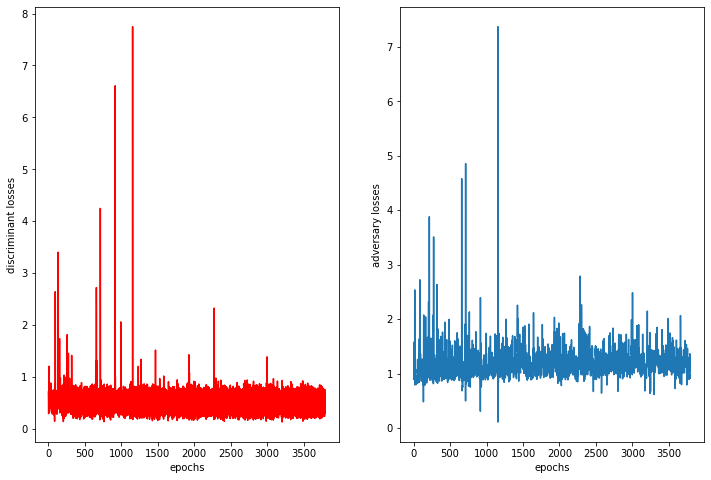

In [45]:
plt.figure(1, figsize=(12, 8))
plt.subplot(121)
plt.plot(d_losses, color='red')
plt.xlabel('epochs')
plt.ylabel('discriminant losses')
plt.subplot(122)
plt.plot(a_losses)
plt.xlabel('epochs')
plt.ylabel('adversary losses')
plt.show()

In [46]:
generated = generator.predict(latent_vectors)

In [47]:
generated.shape

(16, 128, 128, 1)

In [52]:
a=generated[1,:,:,0]

In [53]:
a.shape

(128, 128)

In [56]:
a=np.reshape(a,(128,128))

In [57]:
np.unique(a)

array([-0.00329928, -0.00329361, -0.00272779, ...,  0.00486078,
        0.00495693,  0.00499798], dtype=float32)

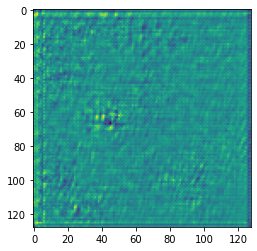

In [58]:
plt.imshow(a)